**11장 – 심층 신경망 훈련하기**

# 설정

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


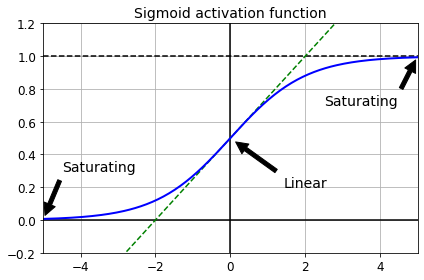

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 초기화와 He 초기화

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


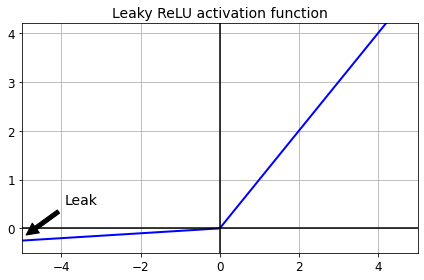

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [11]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련:

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5339 - accuracy: 0.8224 - val_loss: 0.5156 - val_accuracy:

PReLU를 테스트:

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6965 - accuracy: 0.7694 - val_loss: 0.6564 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6330 - accuracy: 0.7908 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


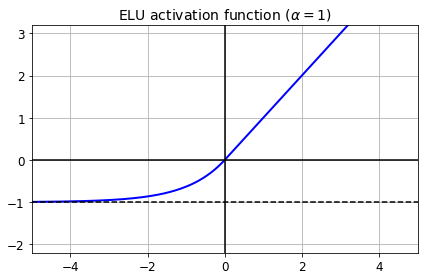

In [20]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있다. 층을 만들 때 활성화 함수로 지정하면 됨:

In [21]:
keras.layers.Dense(10, activation="elu")

### SELU

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했습니다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있습니다. 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 냅니다. 따라서 꼭 시도해 봐야 합니다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다). 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

In [22]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


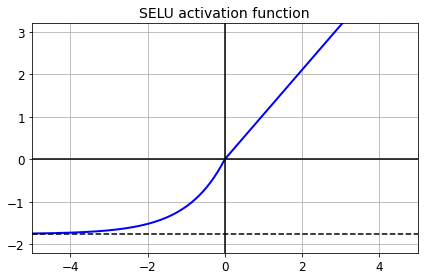

In [24]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정됩니다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지합니다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있습니다:

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


쉽게 SELU를 사용할 수 있습니다:

In [26]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 보자:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

입력을 평균 0과 표준 편차 1로 바꾸어야 한다.

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [31]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.1728 - accuracy: 0.5370 - val_loss: 0.7866 - val_accuracy: 0.6984
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6967 - accuracy: 0.7433 - val_loss: 0.5825 - val_accuracy: 0.7986
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.6482 - accuracy: 0.7652 - val_loss: 0.6131 - val_accuracy: 0.7802
Epoch 4/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.6106 - accuracy: 0.7845 - val_loss: 0.5195 - val_accuracy: 0.8218
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.5167 - accuracy: 0.8183 - val_loss: 0.4954 - val_accuracy: 0.8238


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 보자:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.8048 - accuracy: 0.2784 - val_loss: 1.2769 - val_accuracy: 0.4442
Epoch 2/5
1719/1719 [==============================] - 16s 10ms/step - loss: 1.1708 - accuracy: 0.5058 - val_loss: 0.9293 - val_accuracy: 0.6108
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.9401 - accuracy: 0.6186 - val_loss: 0.8171 - val_accuracy: 0.6576
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.8014 - accuracy: 0.6878 - val_loss: 0.8105 - val_accuracy: 0.7092
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.7538 - accuracy: 0.7133 - val_loss: 0.8972 - val_accuracy: 0.6466


그레이디언트 폭주나 소실 문제가 발생했다.

# 배치 정규화

In [36]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [38]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [39]:
bn1.updates

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[]

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [41]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5189 - accuracy: 0.8205 - val_loss: 0.4376 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4827 - accuracy: 0.8323 - val_loss: 0.4152 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3997 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4398 - accuracy: 0.8474 - val_loss: 0.3866 - val_accuracy: 0.8690
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4242 - accuracy: 0.8514 - val_loss: 0.3762 - val_accuracy:

이따금 활성화 함수전에 BN을 적용해도 잘 동작합니다(여기에는 논란의 여지가 있습니다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없습니다. `BatchNormalization` 층이 이를 무효화하기 때문입니다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있습니다:

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [44]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5109 - accuracy: 0.8278 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4898 - accuracy: 0.8336 - val_loss: 0.4263 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.4130 - val_accuracy:

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원합니다:

In [45]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [46]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 나누어 보죠:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눕니다. 하지만 이미지 개수는 제한하지 않습니다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보겠습니다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대합니다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문입니다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있습니다(반대로 합성곱 층은 훨씬 많은 정보를 전송합니다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문입니다. CNN 장에서 자세히 알아 보겠습니다).

In [47]:
def split_dataset(X, y):
  y_5_or_6 = (y == 5) | (y == 6) # sandals  or shirts
  y_A = y[~y_5_or_6]
  y_A[y_A > 6] -= 2  # class indices 7, 8, 9 should be moved to 5, 6, 7
  y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a hirt (class 6)?
  return ((X[~y_5_or_6], y_A),
          (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape

(43986, 28, 28)

In [49]:
X_train_B.shape

(200, 28, 28)

In [50]:
y_train_A.shape

(43986,)

In [51]:
y_train_B.shape

(200,)

In [52]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [53]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [54]:
tf.random.set_seed(42)
np.random.seed(42)

* model_A 생성

In [55]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
  model_A.add(keras.layers.Dense(n_hidden, activation='selu'))
model_A.add(keras.layers.Dense(8, activation='softmax'))

In [56]:
model_A.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=['accuracy'])

In [57]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A,y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.5927 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3286 - val_accuracy: 0.8829
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3011 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2893 - val_accuracy: 0.9026
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2772 - val_accuracy: 0.9068
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2730 - accuracy: 0.9061 - val_loss: 0.2734 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2642 - accuracy: 0.9094 - val_loss: 0.2719 - val_accuracy:

In [58]:
model_A.save("my_model_A.h5")

* model_B 생성

In [59]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
  model_B.add(keras.layers.Dense(n_hidden, activation='selu'))
model_B.add(keras.layers.Dense(1, activation='sigmoid'))

In [60]:
model_B.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=['accuracy'])

In [61]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 28ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

먼저 모델 A를 로드하고 이 모델의 층을 기반으로 새로운 모델(model_B_on_A)을 만든다.
출력층만 제외하고 모든 층을 재사용한다.

In [63]:
model_A = keras.models.load_model('my_model_A.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

model_A와 model_B_on_A는 일부 층을 공유한다. model_B_ond_A를 훈련할 때 model_A도 영향을 받는다. 이를 원치 않는다면 층을 재사용하기 전에 model_A를 클론해야한다. clone_model() 메서드로 모델 A의 구조를 복제한 후 가중치를 복사한다.(clone_model()메서드는 가중치를 복제하지 않는다.)

In [64]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

새로운 출력층이 랜덤하게 초기화되어 있으므로 큰 오차를 만들 수 있다.(적어도 처음 몇 번의 에포크 동안). 따라서 큰 오차 그레이디언트가 재사용된 가중치를 망칠 수 있다. 이를 피하는 한 가지 방법은 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주는 것이다.

In [65]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",optimizer="sgd",
                     metrics=["accuracy"])

In [66]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 27ms/step - loss: 0.4722 - accuracy: 0.7450 - val_loss: 0.3596 - val_accuracy: 0.8458
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 0.2778 - accuracy: 0.9400 - val_loss: 0.2360 - val_accuracy: 0.9422
Epoch 3/4
7/7 [==============================] - 0s 11ms/step - loss: 0.1833 - accuracy: 0.9650 - val_loss: 0.1777 - val_accuracy: 0.9655
Epoch 4/4
7/7 [==============================] - 0s 12ms/step - loss: 0.1370 - accuracy: 0.9800 - val_loss: 0.1448 - val_accuracy: 0.9828


In [67]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [68]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 28ms/step - loss: 0.1177 - accuracy: 0.9900 - val_loss: 0.1430 - val_accuracy: 0.9828
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.1158 - accuracy: 0.9900 - val_loss: 0.1410 - val_accuracy: 0.9828
Epoch 3/16
7/7 [==============================] - 0s 11ms/step - loss: 0.1139 - accuracy: 0.9900 - val_loss: 0.1391 - val_accuracy: 0.9828
Epoch 4/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1121 - accuracy: 0.9900 - val_loss: 0.1373 - val_accuracy: 0.9828
Epoch 5/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1104 - accuracy: 0.9900 - val_loss: 0.1356 - val_accuracy: 0.9828
Epoch 6/16
7/7 [==============================] - 0s 11ms/step - loss: 0.1087 - accuracy: 0.9900 - val_loss: 0.1339 - val_accuracy: 0.9838
Epoch 7/16
7/7 [==============================] - 0s 11ms/step - loss: 0.1071 - accuracy: 0.9900 - val_loss: 0.1324 - val_accuracy: 0.9848
Epoch 8/16
7/7 [===========

In [69]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1168 - accuracy: 0.9875


[0.11681864410638809, 0.987500011920929]

### 11.2.2 비지도 사전훈련

레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 사용하여 오토인코더나 생성적 적대 신경망과 같은 비지도 학습 모델을 훈련할 수 있다. 그다음 오토인코더나 GAN 판별자의 하위층을 재사용하고 그 위에 새로운 작업에 맞는 출력층을 추가할 수 있다. 그다음 지도 학습으로 (즉, 레이블된 훈련 샘플로) 최종 네트워크를 세밀하게 튜닝한다.

### 11.2.3 보조 작업에서 사전훈련

레이블된 훈련 데이터가 많지 않다면 마지막 선택 사항은 레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에서 첫 번째 신경망을 훈련하는 것이다.

## 11.3 고속 옵티마이저

훈련속도를 크게 높일 수 있는 또 다른 방법으로 표준적인 경사 하강법 오티마이저 대신 더 빠른 옵티마이저를 사용할 수 있다. 모멘텀 최적화, 네스테로프 가속 경사, ADaGrad, RMSProp, Adam, Nadam 옵티마이저

### 11.3.1 모멘텀 최적화

모멘텀 최적화는 이전 그레이디언트가 얼마였는지를 상당히 중요하게 생각한다. 그레이디언트를 속도가 아니라 가속도로 사용한다. 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 이 알고리즘에는 모멘텀이라는 새로운 하이퍼파라미터가 등장한다. 배치 정규화를 사용하지 않는 심층 신경망에서 모멘텀 최적화를 사용하면 큰 도움이 된다. 또한 이 기법은 지역 최적점(local optima)을 건너뛰도록 하는 데도 도움이 된다.

In [70]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### 11.3.2. 네스테로프 가속 경사

In [71]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다. 이를 적응적 학습률이라고 부르며, 전역 최적점 방향으로 더 곧장 가도록 갱신되는 데 도움이 된다.

In [72]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### 11.3.4 RMSProp

In [73]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### 11.3.5 Adam과 Nadam 최적화

* Adam

In [77]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

* AdaMax

In [79]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

* Nadam

In [80]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### 11.3.6 학습률 스케줄링

* 거듭제곱 기반 스케줄링(power scheduling)  
lr = lr0 / (1 + steps / s)**c  
학습률은 각 스텝마다 감소한다.

In [81]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [83]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4855 - accuracy: 0.8304 - val_loss: 0.4027 - val_accuracy: 0.8610
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3780 - accuracy: 0.8657 - val_loss: 0.3716 - val_accuracy: 0.8728
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3458 - accuracy: 0.8771 - val_loss: 0.3745 - val_accuracy: 0.8744
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3250 - accuracy: 0.8830 - val_loss: 0.3498 - val_accuracy: 0.8808
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3101 - accuracy: 0.8891 - val_loss: 0.3447 - val_accuracy: 0.8802
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2966 - accuracy: 0.8936 - val_loss: 0.3415 - val_accuracy: 0.8836
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2868 - accuracy: 0.8974 - val_loss: 0.3357 - val_accuracy:

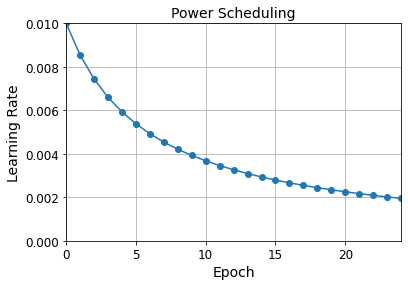

In [84]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_step_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_step_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

* 지수 기반 스케줄링(exponential scheduling)  
lr = lr0 * 0.1**(epoch / s)  
학습률이 s 스텝마다 10배씩 점차 줄어든다.

In [85]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1 **(epoch / 20)

In [87]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return 0.01 * 0.1 **(epoch / 20)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [88]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8607 - accuracy: 0.7554 - val_loss: 0.9979 - val_accuracy: 0.7362
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6690 - accuracy: 0.7997 - val_loss: 0.5308 - val_accuracy: 0.8418
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6351 - accuracy: 0.8124 - val_loss: 0.6579 - val_accuracy: 0.7854
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5195 - accuracy: 0.8387 - val_loss: 0.5769 - val_accuracy: 0.8170
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4724 - accuracy: 0.8511 - val_loss: 0.4727 - val_accuracy: 0.8522
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4507 - accuracy: 0.8591 - val_loss: 0.5218 - val_accuracy: 0.8466
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3969 - accuracy: 0.8718 - val_loss: 0.4517 - val_accuracy:

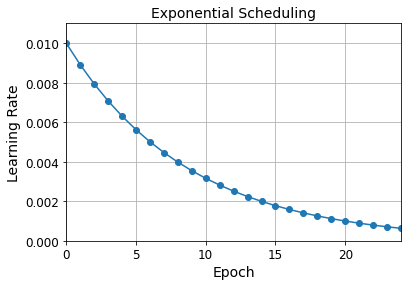

In [90]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

이 스케줄함수는 두번째 매개변수로 현재학습률을 받을 수 있다.

In [91]:
def exponential_decay_fn(epoch, lr):
  return lr * 0.1**(1/20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 한다.

In [92]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8106 - accuracy: 0.7655 - val_loss: 0.9857 - val_accuracy: 0.7318
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6814 - accuracy: 0.7970 - val_loss: 0.5529 - val_accuracy: 0.8262
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6120 - accuracy: 0.8159 - val_loss: 1.7717 - val_accuracy: 0.7310
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5864 - accuracy: 0.8274 - val_loss: 0.5518 - val_accuracy: 0.8398
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5149 - accuracy: 0.8465 - val_loss: 0.5392 - val_accuracy: 0.8522
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4680 - accuracy: 0.8558 - val_loss: 0.4935 - val_accuracy: 0.8588
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4477 - accuracy: 0.8646 - val_loss: 0.5337 - val_accuracy:

In [93]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

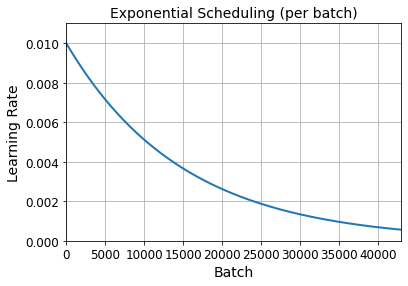

In [94]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

* 구간별 고정 스케줄링(piecewise constant scheduling)  

In [95]:
def piecewise_constant_fn(epoch):
  if epoch < 5:
    return 0.01
  elif epoch < 15:
    return 0.005
  else:
    return 0.001

In [97]:
def piecewise_constant(boundaries, values):
  boundaries = np.array([0] + boundaries)
  values = np.array(values)
  def piecewise_constant_fn(epoch):
    return values[np.argmax(boundaries > epoch) - 1]
  return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5,15], [0.01, 0.005, 0.001])

In [98]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8554 - accuracy: 0.7555 - val_loss: 0.8350 - val_accuracy: 0.7098
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7547 - accuracy: 0.7801 - val_loss: 0.5255 - val_accuracy: 0.8354
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9295 - accuracy: 0.7176 - val_loss: 1.2789 - val_accuracy: 0.5896
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1323 - accuracy: 0.6107 - val_loss: 1.0216 - val_accuracy: 0.6234
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1573 - accuracy: 0.6043 - val_loss: 1.7270 - val_accuracy: 0.5588
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8891 - accuracy: 0.6548 - val_loss: 0.8699 - val_accuracy: 0.6608
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8562 - accuracy: 0.6689 - val_loss: 1.0301 - val_accuracy:

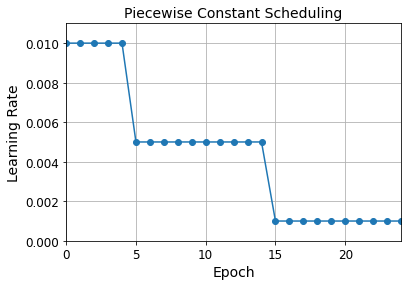

In [99]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

* 성능 기반 스케줄링(perfomance scheduling)  
매 N 스텝마다 (조기 종료처럼) 검증 오차를 측정하고 오차가 줄어들지 않으면 람다 배 만큼 학습률을 감소시킨다.

In [100]:
tf.random.set_seed(42)
np.random.seed(42)

In [101]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5908 - accuracy: 0.8081 - val_loss: 0.4942 - val_accuracy: 0.8484
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4970 - accuracy: 0.8391 - val_loss: 0.5590 - val_accuracy: 0.8364
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5021 - accuracy: 0.8417 - val_loss: 0.4669 - val_accuracy: 0.8586
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5016 - accuracy: 0.8471 - val_loss: 0.4979 - val_accuracy: 0.8546
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5028 - accuracy: 0.8525 - val_loss: 0.5206 - val_accuracy: 0.8490
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4958 - accuracy: 0.8523 - val_loss: 0.6131 - val_accuracy: 0.8426
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5273 - accuracy: 0.8542 - val_loss: 0.5562 - val_accuracy:

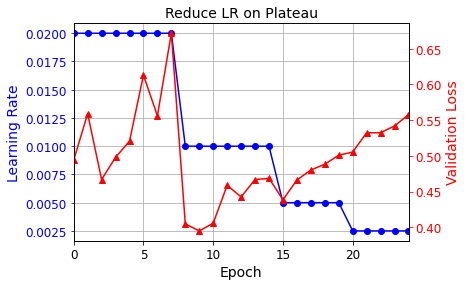

In [102]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

* tf.keras 스케줄러

In [103]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3820 - accuracy: 0.8652 - val_loss: 0.3740 - val_accuracy: 0.8704
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3487 - accuracy: 0.8765 - val_loss: 0.3731 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3264 - accuracy: 0.8837 - val_loss: 0.3494 - val_accuracy: 0.8812
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3104 - accuracy: 0.8899 - val_loss: 0.3432 - val_accuracy: 0.8792
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2958 - accuracy: 0.8953 - val_loss: 0.3416 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2854 - accuracy: 0.8989 - val_loss: 0.3355 - val_accuracy:

구간별 고정 스케줄링은 다음을 사용

In [105]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_step_per_epoch, 15. * n_step_per_epoch],
    values=[0.01, 0.005, 0.001])

* 1 사이클 스케줄링(1cycle scheduling)